In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.linear import *
import matplotlib.pyplot as plt
import time
import math

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
in_feature = 16
out_feature = 8
bias = True
bitwidth = 8
rounding = "round"

total_bit = 16
input_int_bit = 3
input_fra_bit = total_bit - input_int_bit

input = ((torch.rand(256, in_feature) - 0.5) * 2**(2*input_int_bit)).round().div(2**(input_int_bit)).to(device)

fc = torch.nn.Linear(in_feature, out_feature, bias=bias).to(device)
fc_o = fc(input)

ufc = FxpLinear(in_feature, out_feature, bias=bias, binary_weight=fc.weight.data, binary_bias=fc.bias, bitwidth=bitwidth, rounding=rounding).to(device)
ufc_o = ufc(input)

(fc_o - ufc_o).abs().mean().backward()



diff max: tensor(1.8884, device='cuda:0', grad_fn=<MaxBackward1>)
diff min: tensor(-1.8117, device='cuda:0', grad_fn=<MinBackward1>)
diff mean: tensor(0.0061, device='cuda:0', grad_fn=<MeanBackward0>)


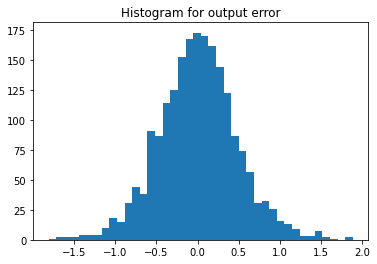

In [5]:
diff = (ufc_o - fc_o)
print("diff max:", diff.max())
print("diff min:", diff.min())
print("diff mean:", diff.mean())

fig = plt.hist(diff.cpu().detach().numpy().flatten(), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for output error")
plt.show()

diff grad max: tensor(0.4332, device='cuda:0')
diff grad min: tensor(-0.2789, device='cuda:0')
diff grad mean: tensor(0.0044, device='cuda:0')


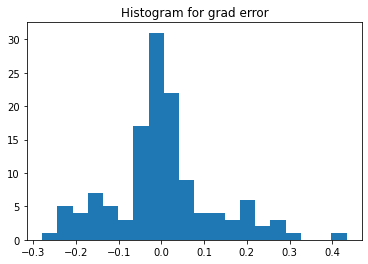

In [6]:
diff_grad = (ufc.weight.grad - fc.weight.grad)
print("diff grad max:", diff_grad.max())
print("diff grad min:", diff_grad.min())
print("diff grad mean:", diff_grad.mean())

fig = plt.hist(diff_grad.cpu().detach().numpy().flatten(), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for grad error")
plt.show()

In [7]:
print(ufc_o)

tensor([[ 2.4503,  0.2545, -0.0288,  ..., -0.0743,  0.3957,  0.4282],
        [ 1.2024,  0.9870,  0.4832,  ...,  0.6027,  0.3820,  0.2976],
        [ 0.7909,  0.0490,  0.4655,  ...,  0.4783, -0.6596,  1.3464],
        ...,
        [-1.0328,  1.0870, -1.1441,  ...,  0.1413,  1.0893, -0.9512],
        [-0.0361, -0.2466,  0.5202,  ..., -0.6292,  0.3449, -1.1387],
        [-1.7426, -1.1932, -1.2201,  ..., -0.3899,  0.4947, -0.5037]],
       device='cuda:0', grad_fn=<FxpLinearFunctionBackward>)
